In [8]:
# import cv2

# source = cv2.VideoCapture(0)

# win_name = 'camera'

# cv2.namedWindow(win_name, cv2.WINDOW_OPENGL)
# cv2.resizeWindow(win_name, 1920,1080)

# while cv2.waitKey(1) != 27:
#     has_frame, frame = source.read()
#     if not has_frame:
#         break

#     frame = cv2.flip(frame, 1)

#     cv2.imshow(win_name, frame)

# source.release()
# cv2.destroyWindow(win_name)



In [9]:
# import cv2
# import os

# source = cv2.VideoCapture(0)

# win_name = 'camera'

# cv2.namedWindow(win_name, cv2.WINDOW_OPENGL)
# cv2.resizeWindow(win_name, 1920,1080)

# prototxt = os.path.join("resources", "deploy.prototxt")
# model = os.path.join("resources", "res10_300x300_ssd_iter_140000_fp16.caffemodel")

# net = cv2.dnn.readNetFromCaffe(prototxt, model)


# # model parameters
# in_width = 300
# in_height = 300
# mean = [104, 117, 123]
# conf_threshold = 0.7

# while cv2.waitKey(1) != 27:
#     has_frame, frame = source.read()
#     if not has_frame:
#         break
    
#     frame = cv2.flip(frame, 1)
#     frame_height = frame.shape[0]
#     frame_width = frame.shape[1]


#     blob = cv2.dnn.blobFromImage(frame, 1.0, (in_width, in_height), mean, swapRB=False, crop=False)

#     net.setInput(blob)
#     detections = net.forward()

#     for i in range(detections.shape[2]):
#         confidence = detections[0, 0, i, 2]
#         if confidence > conf_threshold:
#             x_top_left = int(detections[0, 0, i, 3] * frame_width)
#             y_top_left = int(detections[0, 0, i, 4] * frame_height)
#             x_bottom_right = int(detections[0, 0, i, 5] * frame_width)
#             y_bottom_right = int(detections[0, 0, i, 6] * frame_height)

#             cv2.rectangle(frame, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (0, 255, 0), 4)

#     cv2.imshow(win_name, frame)

# source.release()
# cv2.destroyWindow(win_name)



In [10]:
import csv
import os

class_map = {}

with open(os.path.join("resources", "GoogleNet", 'classes.csv'), 'r', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        class_map[row['Class ID']] = row['Class Name']

print(class_map['932'])


pretzel


Na obrazku je: papillon s pravděpodobností 99.90%


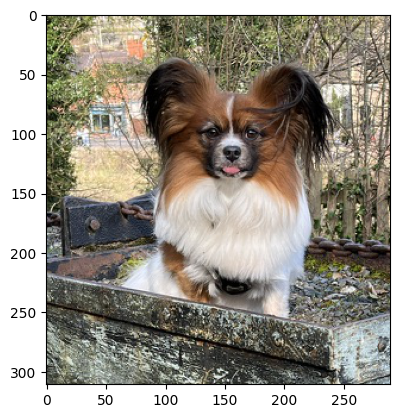

In [11]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = cv2.imread(os.path.join('resources', 'abinek2.jpeg'))

prototxt = os.path.join("resources", 'GoogleNet' ,"deploy.prototxt")
model = os.path.join("resources", 'GoogleNet' ,"bvlc_googlenet.caffemodel")

net = cv2.dnn.readNetFromCaffe(prototxt, model)


# model parameters
in_width = 224
in_height = 224
mean = [104, 117, 123]
conf_threshold = 0.7

blob = cv2.dnn.blobFromImage(img, 1.0, (in_width, in_height), mean, swapRB=False, crop=False)

net.setInput(blob)
detections = net.forward()


max_value = np.max(detections)


index = np.argwhere(detections == max_value)
print(f"Na obrazku je: {class_map[str(index[0][1])]} s pravděpodobností {max_value * 100:.2f}%")


plt.imshow(img[:, :, ::-1])

In [12]:
index[0][1]

np.int64(157)

In [13]:
import cv2
import os
import numpy as np

def classify_image(img, net, thresh):

    # model parameters
    in_width = 224
    in_height = 224
    mean = [104, 117, 123]
    conf_threshold = thresh

    blob = cv2.dnn.blobFromImage(img, 1.0, (in_width, in_height), mean, swapRB=False, crop=False)

    net.setInput(blob)
    detections = net.forward()


    max_value = np.max(detections)

    #print(max_value)

    index = np.argwhere(detections == max_value)

    if max_value < conf_threshold:
        return None
    
    else:
        return class_map[str(index[0][1]), round(max_value, 2)]
    

In [14]:
class MouseTracker:
    def __init__(self, win_dims, delta):
        self.position = (0, 0)
        self.scroll_val = 50
        self.delta = delta
        self.win_dims = win_dims

    def mouse_event(self, event, x, y, flags, param):
        if event == cv2.EVENT_MOUSEMOVE:
            self.position = (x, y)

        elif event == cv2.EVENT_MOUSEHWHEEL:
            if flags > 0:
                if (self.scroll_val + self.delta) < self.win_dims[0] and (self.scroll_val + self.delta) < self.win_dims[1]:
                    self.scroll_val += self.delta   # scroll up
            else:
                if (self.scroll_val - self.delta) > 50:
                    self.scroll_val -= self.delta   # scroll down 

In [ ]:
import cv2
import os

source = cv2.VideoCapture(0)

win_name = 'camera'

cv2.namedWindow(win_name, cv2.WINDOW_OPENGL)
cv2.resizeWindow(win_name, 1920,1080)

prototxt = os.path.join("resources", 'GoogleNet' ,"deploy.prototxt")
model = os.path.join("resources", 'GoogleNet' ,"bvlc_googlenet.caffemodel")

net = cv2.dnn.readNetFromCaffe(prototxt, model)

tracker = MouseTracker((1920, 1080), 5)
cv2.setMouseCallback(win_name, tracker.mouse_event)

while cv2.waitKey(1) != 27:
    has_frame, frame = source.read()
    if not has_frame:
        break
    
    frame = cv2.flip(frame, 1)
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    rect_w = tracker.scroll_val
    rect_h = tracker.scroll_val
    color = (0, 255, 0)

    crop_img = frame[tracker.position[1]:tracker.position[1] + rect_w,
                     tracker.position[0]:tracker.position[0] + rect_h]
    
    try:
        classification_res = classify_image(crop_img, net, 0.7)

    except:
        last_classification = None

    cv2.putText(frame, str(classification_res), (tracker.position[0], tracker.position[1] + rect_h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0)[::-1])
    cv2.rectangle(frame, tracker.position, (tracker.position[0] + rect_w,
                                            tracker.position[1] + rect_h),
                                            color,2)

    cv2.imshow(win_name, frame)

source.release()
cv2.destroyWindow(win_name)

2025-03-22 18:15:12.524 python[13529:271834] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2025-03-22 18:15:13.599 python[13529:271834] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-22 18:15:13.599 python[13529:271834] +[IMKInputSession subclass]: chose IMKInputSession_Modern


: 

In [1]:
import torch

model_path = "models/udnie.pth"  # nebo tvá cesta

state_dict = torch.load(model_path, map_location="cpu")

# Zobraz info o klíčích
print(f"🔑 Počet parametrů: {len(state_dict)}")
print("🔍 Ukázka klíčů:")
for key in list(state_dict.keys())[:10]:
    print(f" - {key}")

🔑 Počet parametrů: 92
🔍 Ukázka klíčů:
 - conv1.conv2d.weight
 - conv1.conv2d.bias
 - in1.weight
 - in1.bias
 - in1.running_mean
 - in1.running_var
 - conv2.conv2d.weight
 - conv2.conv2d.bias
 - in2.weight
 - in2.bias


In [5]:
import os
import torch

models_dir = "models"
results = []

def is_transformer_style_model(state_dict_keys):
    expected_keywords = ["conv1", "conv2", "res1", "in1", "in2"]
    matches = sum(any(k.startswith(e) for k in state_dict_keys) for e in expected_keywords)
    return matches >= 3

for file in os.listdir(models_dir):
    if file.endswith(".pth"):
        path = os.path.join(models_dir, file)
        try:
            state_dict = torch.load(path, map_location="cpu")
            keys = list(state_dict.keys()) if isinstance(state_dict, dict) else []
            compatible = is_transformer_style_model(keys)
            results.append((file, len(keys), compatible))
        except Exception as e:
            results.append((file, 0, False, f"❌ ERROR: {str(e)}"))

# Výpis výsledků
print("\n📋 Kompatibilita modelů:")
for r in results:
    if len(r) == 3:
        print(f"✅ {r[0]:30} | {r[1]:>3} klíčů | TransformerNet kompatibilní: {r[2]}")
    else:
        print(f"❌ {r[0]:30} | Chyba: {r[3]}")


📋 Kompatibilita modelů:
✅ starry-night.pth               |  62 klíčů | TransformerNet kompatibilní: True
✅ rain_princess.pth              |  92 klíčů | TransformerNet kompatibilní: True
✅ udnie.pth                      |  92 klíčů | TransformerNet kompatibilní: True
✅ mosaic.pth                     |  92 klíčů | TransformerNet kompatibilní: True
✅ candy.pth                      |  92 klíčů | TransformerNet kompatibilní: True
